# Day 1
## Phase 2


In [25]:
import os
import tarfile
import requests
import pandas as pd
from pathlib import Path
from pydantic import BaseModel, ConfigDict
from typing import Optional

class MovieData(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)  
    movie_df: Optional[pd.DataFrame] = None
    character_df: Optional[pd.DataFrame] = None
    data_url: str = "http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz"
    download_dir: Path = Path("downloads")
    extracted_dir: Path = download_dir / "MovieSummaries"

    def __init__(self):
        """Runs the download, extraction, and data loading process."""
        super().__init__()
        self.download_dir.mkdir(exist_ok=True)
        self._download_data()
        self._extract_data()
        self._load_movie_data()
        self._load_character_data()
    
        if hasattr(self, "movie_df") and self.movie_df is not None:
            print("✅ `movie_df` successfully loaded!")
        else:
             print("❌ `movie_df` is missing or not assigned properly!")

    def _download_data(self):
        """Downloads the dataset if it doesn't already exist."""
        file_path = self.download_dir / "MovieSummaries.tar.gz"
        if not file_path.exists():
            print("Downloading dataset...")
            response = requests.get(self.data_url, stream=True)
            response.raise_for_status()  # Raise an error if the request fails
            with open(file_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)
            print("Download complete.")
        else:
            print("Dataset already exists. Skipping download.")

    def _extract_data(self):
        """Extracts the dataset if not already extracted."""
        file_path = self.download_dir / "MovieSummaries.tar.gz"
        if not self.extracted_dir.exists():
            print("Extracting dataset...")
            with tarfile.open(file_path, "r:gz") as tar_ref:
                def safe_extract(tar, path=".", members=None, *, numeric_owner=False):
                    for member in tar.getmembers():
                        member_path = os.path.join(path, member.name)
                        if not os.path.commonprefix([os.path.abspath(path), os.path.abspath(member_path)]) == os.path.abspath(path):
                            raise Exception("Attempted Path Traversal in Tar File")
                    tar.extractall(path, members, numeric_owner=numeric_owner) 

                safe_extract(tar_ref, self.download_dir)
    
    def _load_movie_data(self):
        """Loads the movie metadata into a DataFrame with proper column names."""
        movie_file = self.extracted_dir / "movie.metadata.tsv"
        
        movie_columns = [
            'Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_Name', 'Movie_release_Date',
            'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries', 'Movie_genres'
        ]
        
        if movie_file.exists():
            self.movie_df = pd.read_csv(movie_file, sep='\t', header=None, encoding='utf-8')
            self.movie_df.columns = movie_columns  
            print("Movie data successfully loaded into DataFrame with column names.")
            print(self.movie_df.head())
        else:
            raise FileNotFoundError(f"Movie data file not found at {movie_file}")

    def _load_character_data(self):
        """Loads the character metadata into a DataFrame with proper column names."""
        character_file = self.extracted_dir / "character.metadata.tsv"
        
        character_columns = [
            'Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date',
            'Character_name', 'Actor_date_of_birth', 'Actor_Gender', 'Actor_height',
            'Actor_ethnicity', 'Actor_name', 'Actor_age_at_movie_release',
            'Freebase_character/actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID'
        ]
        
        if character_file.exists():
            self.character_df = pd.read_csv(character_file, sep='\t', header=None, encoding='utf-8')
            self.character_df.columns = character_columns  
            print("Character data successfully loaded into DataFrame with column names.")
            print(self.character_df.head())
        else:
            raise FileNotFoundError(f"Character data file not found at {character_file}")

            
# Create an instance and call setup() to run everything
movie_data = MovieData()

Dataset already exists. Skipping download.
Movie data successfully loaded into DataFrame with column names.
   Wikipedia_movie_ID Freebase_movie_ID  \
0              975900         /m/03vyhn   
1             3196793         /m/08yl5d   
2            28463795        /m/0crgdbh   
3             9363483        /m/0285_cd   
4              261236         /m/01mrr1   

                                          Movie_Name Movie_release_Date  \
0                                     Ghosts of Mars         2001-08-24   
1  Getting Away with Murder: The JonBenét Ramsey ...         2000-02-16   
2                                        Brun bitter               1988   
3                                   White Of The Eye               1987   
4                                  A Woman in Flames               1983   

   Movie_box_office_revenue  Movie_runtime  \
0                14010832.0           98.0   
1                       NaN           95.0   
2                       NaN           83.0  

In [26]:
import ast

def clean_column_values(df: pd.DataFrame, column_name: str):
    """Cleans a column by extracting the genre, country, or language names."""
    if column_name in df.columns:
        # Use ast.literal_eval to safely convert the string to a dictionary
        df[column_name] = df[column_name].apply(
            lambda x: ', '.join(list(ast.literal_eval(x).values())) if isinstance(x, str) else ''
        )
        print(f"{column_name} successfully cleaned.")
    else:
        print(f"Column '{column_name}' not found in DataFrame.")

# Clean the columns for Movie_genres, Movie_countries, and Movie_languages
clean_column_values(movie_data.movie_df, 'Movie_genres')
clean_column_values(movie_data.movie_df, 'Movie_countries')
clean_column_values(movie_data.movie_df, 'Movie_languages')

# Print cleaned data
print(movie_data.movie_df[['Movie_Name', 'Movie_genres', 'Movie_countries', 'Movie_languages']].head())



Movie_genres successfully cleaned.
Movie_countries successfully cleaned.
Movie_languages successfully cleaned.
                                          Movie_Name  \
0                                     Ghosts of Mars   
1  Getting Away with Murder: The JonBenét Ramsey ...   
2                                        Brun bitter   
3                                   White Of The Eye   
4                                  A Woman in Flames   

                                        Movie_genres  \
0  Thriller, Science Fiction, Horror, Adventure, ...   
1     Mystery, Biographical film, Drama, Crime Drama   
2                               Crime Fiction, Drama   
3  Thriller, Erotic thriller, Psychological thriller   
4                                              Drama   

            Movie_countries     Movie_languages  
0  United States of America    English Language  
1  United States of America    English Language  
2                    Norway  Norwegian Language  
3            Un

In [27]:
# Check for null and NaN values in movie_df
print("Null and NaN values in movie_df:")
print(movie_data.movie_df.isnull().sum())

# Check for null and NaN values in character_df
print("Null and NaN values in character_df:")
print(movie_data.character_df.isnull().sum())

Null and NaN values in movie_df:
Wikipedia_movie_ID              0
Freebase_movie_ID               0
Movie_Name                      0
Movie_release_Date           6902
Movie_box_office_revenue    73340
Movie_runtime               20450
Movie_languages                 0
Movie_countries                 0
Movie_genres                    0
dtype: int64
Null and NaN values in character_df:
Wikipedia_movie_ID                      0
Freebase_movie_ID                       0
Movie_release_date                   9995
Character_name                     257875
Actor_date_of_birth                106145
Actor_Gender                        45609
Actor_height                       295845
Actor_ethnicity                    344611
Actor_name                           1228
Actor_age_at_movie_release         158113
Freebase_character/actor_map_ID         0
Freebase_character_ID              257865
Freebase_actor_ID                     815
dtype: int64


In [28]:
# Identify columns with null or NaN values in movie_df
null_columns_movie_df = movie_data.movie_df.columns[movie_data.movie_df.isnull().any()]

# Calculate skewness for columns with null or NaN values in movie_df
print("Skewness of columns with null or NaN values in movie_df:")
for column in null_columns_movie_df:
    if pd.api.types.is_numeric_dtype(movie_data.movie_df[column]):
        skewness = movie_data.movie_df[column].dropna().skew()
        print(f"{column}: {skewness}")
    else:
        print(f"{column}: Non-numeric data, skewness calculation skipped.")

# Identify columns with null or NaN values in character_df
null_columns_character_df = movie_data.character_df.columns[movie_data.character_df.isnull().any()]

# Calculate skewness for columns with null or NaN values in character_df
print("Skewness of columns with null or NaN values in character_df:")
for column in null_columns_character_df:
    if pd.api.types.is_numeric_dtype(movie_data.character_df[column]):
        skewness = movie_data.character_df[column].dropna().skew()
        print(f"{column}: {skewness}")
    else:
        print(f"{column}: Non-numeric data, skewness calculation skipped.")

Skewness of columns with null or NaN values in movie_df:
Movie_release_Date: Non-numeric data, skewness calculation skipped.
Movie_box_office_revenue: 6.671399016590445
Movie_runtime: 247.40823732489062
Skewness of columns with null or NaN values in character_df:
Movie_release_date: Non-numeric data, skewness calculation skipped.
Character_name: Non-numeric data, skewness calculation skipped.
Actor_date_of_birth: Non-numeric data, skewness calculation skipped.
Actor_Gender: Non-numeric data, skewness calculation skipped.
Actor_height: 112.73207924910541
Actor_ethnicity: Non-numeric data, skewness calculation skipped.
Actor_name: Non-numeric data, skewness calculation skipped.
Actor_age_at_movie_release: -196.2241024803784
Freebase_character_ID: Non-numeric data, skewness calculation skipped.
Freebase_actor_ID: Non-numeric data, skewness calculation skipped.


In [29]:
# Fill NaN values in numeric columns of movie_df with their respective medians
for column in null_columns_movie_df:
    if pd.api.types.is_numeric_dtype(movie_data.movie_df[column]):
        median_value = movie_data.movie_df[column].median()
        movie_data.movie_df[column] = movie_data.movie_df[column].fillna(median_value)
        print(f"Filled NaN values in '{column}' with median value {median_value}")

# Fill NaN values in numeric columns of character_df with their respective medians
for column in null_columns_character_df:
    if pd.api.types.is_numeric_dtype(movie_data.character_df[column]):
        median_value = movie_data.character_df[column].median()
        movie_data.character_df[column] = movie_data.character_df[column].fillna(median_value)
        print(f"Filled NaN values in '{column}' with median value {median_value}")


Filled NaN values in 'Movie_box_office_revenue' with median value 10639686.0
Filled NaN values in 'Movie_runtime' with median value 93.0
Filled NaN values in 'Actor_height' with median value 1.75
Filled NaN values in 'Actor_age_at_movie_release' with median value 36.0


In [30]:
print(movie_data.movie_df.head())


   Wikipedia_movie_ID Freebase_movie_ID  \
0              975900         /m/03vyhn   
1             3196793         /m/08yl5d   
2            28463795        /m/0crgdbh   
3             9363483        /m/0285_cd   
4              261236         /m/01mrr1   

                                          Movie_Name Movie_release_Date  \
0                                     Ghosts of Mars         2001-08-24   
1  Getting Away with Murder: The JonBenét Ramsey ...         2000-02-16   
2                                        Brun bitter               1988   
3                                   White Of The Eye               1987   
4                                  A Woman in Flames               1983   

   Movie_box_office_revenue  Movie_runtime     Movie_languages  \
0                14010832.0           98.0    English Language   
1                10639686.0           95.0    English Language   
2                10639686.0           83.0  Norwegian Language   
3                10639686.

## Phase 3

In [43]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns


In [44]:
def movie_type(self, N: int = 10) -> pd.DataFrame:
    """
    Returns the N most common movie genres with their counts.
    
    Parameters:
        N (int): Number of top genres to return.
    
    Returns:
        pd.DataFrame: DataFrame with 'Genre' and 'Count' columns.
    """
    column_with_genres = "Movie_genres"

    if not hasattr(self, "movie_df") or self.movie_df is None:
        raise ValueError("Data has not been loaded. Ensure `movie_df` exists.")

    # Convert string-encoded dictionary to proper format
    if isinstance(self.movie_df[column_with_genres].iloc[0], str):
        self.movie_df[column_with_genres] = self.movie_df[column_with_genres].apply(
            lambda x: list(ast.literal_eval(x).values()) if isinstance(x, str) else []
        )

    genre_counts = self.movie_df[column_with_genres].explode().value_counts().head(N)
    return genre_counts.reset_index().rename(columns={"index": "Genre", 0: "Count"})


In [45]:
def actor_count(self) -> pd.DataFrame:
    """
    Returns the distribution of the number of actors per movie.
    
    Returns:
        pd.DataFrame: DataFrame with 'Number of Actors' and 'Movie Count'.
    """
    column_with_movie_id = "Wikipedia_movie_ID"

    if not hasattr(self, "character_df") or self.character_df is None:
        raise ValueError("Data has not been loaded. Ensure `character_df` exists.")

    # Count actors per movie
    actor_distribution = self.character_df.groupby(column_with_movie_id).size()

    return actor_distribution.value_counts().reset_index().rename(
        columns={"index": "Number of Actors", 0: "Movie Count"}
    )


In [51]:
def actor_distributions(self, gender: str, max_height: float, min_height: float, plot: bool = False) -> pd.DataFrame:
    """
    Returns actors filtered by gender and height range. Optionally plots the height distribution.

    Parameters:
        gender (str): Gender to filter ('m', 'f', or 'all').
        max_height (float): Maximum height for filtering.
        min_height (float): Minimum height for filtering.
        plot (bool): Whether to generate a histogram plot.

    Returns:
        pd.DataFrame: DataFrame with filtered actors.
    """
    column_with_gender = "Actor_Gender"
    column_with_height = "Actor_height"

    if not hasattr(self, "character_df") or self.character_df is None:
        raise ValueError("Data has not been loaded. Ensure `character_df` exists.")

    # Validate gender input
    if gender.lower() not in ["m", "f", "all"]:
        raise ValueError("Gender must be 'm', 'f', or 'all'.")

    # Validate height inputs
    if not (isinstance(min_height, (int, float)) and isinstance(max_height, (int, float))):
        raise TypeError("Height values must be numeric.")
    if min_height > max_height:
        raise ValueError("min_height must be less than max_height.")

    # Filter data
    filtered_df = self.character_df.dropna(subset=[column_with_height]).copy()  # Remove NaNs

    # Convert height to float
    filtered_df[column_with_height] = pd.to_numeric(filtered_df[column_with_height], errors="coerce") * 100

    # Apply gender filter
    if gender.lower() != "all":
        filtered_df = filtered_df[filtered_df[column_with_gender].str.lower() == gender.lower()]

    # Apply height filter
    filtered_df = filtered_df[filtered_df[column_with_height].between(min_height, max_height)]

    # Plot if requested
    if plot:
        plt.figure(figsize=(8, 5))
        sns.histplot(filtered_df[column_with_height], bins=30, kde=True)
        plt.xticks(np.arange(150, 200, 5))
        plt.xlim(150, 200)
        plt.xlabel("Height (cm)")
        plt.ylabel("Count")
        plt.title(f"Height Distribution of {gender.upper()} Actors")
        plt.show()

    return filtered_df


In [52]:
MovieData.movie_type = movie_type
MovieData.actor_count = actor_count
MovieData.actor_distributions = actor_distributions


In [36]:
# Create an instance of MovieData
movie_data = MovieData()


Dataset already exists. Skipping download.
Movie data successfully loaded into DataFrame with column names.
   Wikipedia_movie_ID Freebase_movie_ID  \
0              975900         /m/03vyhn   
1             3196793         /m/08yl5d   
2            28463795        /m/0crgdbh   
3             9363483        /m/0285_cd   
4              261236         /m/01mrr1   

                                          Movie_Name Movie_release_Date  \
0                                     Ghosts of Mars         2001-08-24   
1  Getting Away with Murder: The JonBenét Ramsey ...         2000-02-16   
2                                        Brun bitter               1988   
3                                   White Of The Eye               1987   
4                                  A Woman in Flames               1983   

   Movie_box_office_revenue  Movie_runtime  \
0                14010832.0           98.0   
1                       NaN           95.0   
2                       NaN           83.0  

In [53]:
print(movie_data.character_df["Actor_height"].value_counts())


Actor_height
1.78000    8434
1.70000    8043
1.80000    7941
1.83000    7633
1.75000    7632
           ... 
1.60200       1
2.35600       1
0.94000       1
1.09728       1
2.31000       1
Name: count, Length: 221, dtype: int64


      Movie_genres  count
0            Drama  34007
1           Comedy  16349
2     Romance Film  10234
3  Black-and-white   9094
4           Action   8798
    Number of Actors  count
0                  1   8810
1                  2   6690
2                  3   5917
3                  4   5165
4                 10   4332
..               ...    ...
62                68      1
63                71      1
64                49      1
65                61      1
66               115      1

[67 rows x 2 columns]


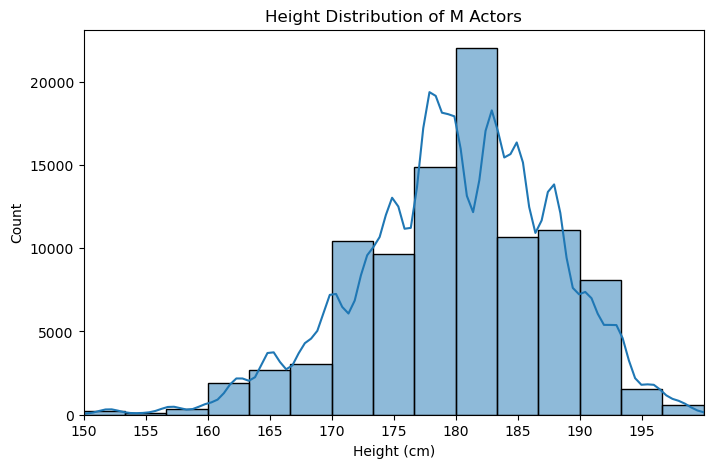

        Wikipedia_movie_ID Freebase_movie_ID Movie_release_date  \
2                   975900         /m/03vyhn         2001-08-24   
3                   975900         /m/03vyhn         2001-08-24   
8                   975900         /m/03vyhn         2001-08-24   
12                  975900         /m/03vyhn         2001-08-24   
22                 3196793         /m/08yl5d         2000-02-16   
...                    ...               ...                ...   
450626            31627556        /m/0gmdz8p         2011-08-24   
450627            23687925        /m/06zmdnc               1952   
450632            30553937        /m/0g9ts5h         1998-03-07   
450644            12476867        /m/02w7zz8               2002   
450666            28308153        /m/0cp05t9               1957   

             Character_name Actor_date_of_birth Actor_Gender  Actor_height  \
2       Desolation Williams          1969-06-15            M         172.7   
3        Sgt Jericho Butler          19

In [54]:
print(movie_data.movie_type(5))        # ✅ Get top 5 movie genres
print(movie_data.actor_count())        # ✅ Get actor count distribution
print(movie_data.actor_distributions("m", 200, 100, plot=True))  # ✅ Test height distribution
